In [156]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import OrdinalEncoder
from itertools import product

pd.options.display.max_columns = 50
pd.options.mode.chained_assignment = None
%matplotlib inline

In [157]:
def fix_time(df):
    time = []
    date_fx = []
    months = {"Jan": 1, "Feb": 2, "Mar": 3,
              "Apr": 4, "May": 5, "Jun": 6,
              "Jul": 7, "Aug": 8, "Sep": 9,
              "Oct": 10, "Nov": 11, "Dec": 12
             }
    for date in df["date"]:
        mas = date.split()
        date_fx.append(datetime.date(int(mas[2][:-1]), months[mas[1]], int(mas[0])))
        podmas = mas[-1].split(":")
        time.append(datetime.time(int(podmas[0]), int(podmas[1]), 0))
    df["time"] = time
    df["date"] = date_fx
    
    
def fix_names1(players):
    arr = []
    for x in players['name']:
        surname = ''
        tmp = x.split(' ')
        if len(tmp) > 1:
            surname = tmp[-1]
            name = tmp[0][0] + '.'
            arr.append(surname + " " + name)
        else:
            arr.append(None)
    players['name'] = arr
    
def fix_names2(players):
    arr = []
    for x in players['name']:
        surname = ''
        tmp = x.split(' ')
        if len(tmp) > 1:
            surname = " ".join(tmp[1:])
            name = tmp[0][0] + '.'
            arr.append(surname + " " + name)
        else:
            arr.append(None)
    players['name'] = arr

def add_stats(df, players, set_):
    df['p1_height'] = [None for x in range(len(df))]
    df['p1_age'] = [None for x in range(len(df))]
    df['p1_hand'] = [None for x in range(len(df))]
    df['p1_rank'] = [None for x in range(len(df))]
    df['p1_nation'] = [None for x in range(len(df))]
    df['p2_height'] = [None for x in range(len(df))]
    df['p2_age'] = [None for x in range(len(df))]
    df['p2_hand'] = [None for x in range(len(df))]
    df['p2_rank'] = [None for x in range(len(df))]
    df['p2_nation'] = [None for x in range(len(df))]
    arr1_player1 = []
    arr1_player2 = []
    arr2_player1 = []
    arr2_player2 = []
    arr3_player1 = []
    arr3_player2 = []
    arr4_player1 = []
    arr4_player2 = []
    arr5_player1 = []
    arr5_player2 = []
    for i in range(len(df)):
        try:
            player1 = players[df['player1'][i]:].head(1)
            arr1_player1.append(player1['height'][0])
            arr2_player1.append(player1['birth_date'][0])
            arr4_player1.append(player1['hand'][0])
            arr5_player1.append(player1['rank'][0])
            arr3_player1.append(player1['nationality'][0])
        except Exception:
            arr1_player1.append(df['p1_height'][i])
            arr2_player1.append(df['p1_age'][i])
            arr3_player1.append(df['p1_hand'][i])
            arr4_player1.append(df['p1_rank'][i])
            arr5_player1.append(df['p1_nation'][i])
            set_.add(df['player1'][i])
            
        try:
            player2 = players[df['player2'][i]:].head(1)
            arr1_player2.append(player2['height'][0])
            arr2_player2.append(player2['birth_date'][0])
            arr4_player2.append(player2['hand'][0])
            arr5_player2.append(player2['rank'][0])
            arr3_player2.append(player2['nationality'][0])
        except Exception:
            arr1_player2.append(df['p2_height'][i])
            arr2_player2.append(df['p2_age'][i])
            arr3_player2.append(df['p2_hand'][i])
            arr4_player2.append(df['p2_rank'][i])
            arr5_player2.append(df['p2_nation'][i])
            set_.add(df['player2'][i])
            
    df['p1_height'] = arr1_player1
    df['p2_height'] = arr1_player2
    df['p1_birth'] = arr2_player1
    df['p2_birth'] = arr2_player2
    df['p1_nation'] = arr3_player1
    df['p2_nation'] = arr3_player2
    df['p1_hand'] = arr4_player1
    df['p2_hand'] = arr4_player2
    df['p1_rank'] = arr5_player1
    df['p2_rank'] = arr5_player2
    
def fix_age(df, player_num):
    time = []
    date_fx = []
    months = {"Jan": 1, "Feb": 2, "Mar": 3,
              "Apr": 4, "May": 5, "Jun": 6,
              "Jul": 7, "Aug": 8, "Sep": 9,
              "Oct": 10, "Nov": 11, "Dec": 12
             }
    for date in df["p{0}_birth".format(str(player_num))]:
        if type(date) != float and date != None:
            mas = date.split()
            date_fx.append(datetime.date(int(mas[-1]), months[mas[1]], int(mas[0])))
        else:
            date_fx.append(None)
    df["p{0}_birth".format(str(player_num))] = date_fx

def invert_dataframe(df):
    for x in df.keys():
        if ('player1' in x or x == 'k1') and x != 'player1_win':
            name2 = x[:-1] + '2'
            tmp = df[x].copy()
            df[x]= df[name2]
            df[name2] = tmp
    for i in range(len(df)):
        if df['player1_win'][i] == 1:
            df['player1_win'][i] = 0
        else:
            df['player1_win'][i] = 1
            
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

def lagged_features(df
    ,target_var = ['aces_match_player1']
    , lags = [1]
    , windows = [28]
    , aggregation_methods = {'mean', 'median', percentile(10), percentile(90)}
    , surface_type_filter = [1, -1]):
    ## with no surface type filter
    players = ['player1', 'player2']
    df = df.reset_index()
    for p in players:
        if -1 in surface_type_filter:
            for l, w, t in product(lags, windows, target_var):
                t1 = t
                if p == 'player2':
                    t1 = t1.replace("player1", "player2")
                lf_df = df.set_index(['player1', 'player2', 'date'])[t1].\
                         groupby(level=p).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods).shift(l))
                t1 = t1.replace("player1", "").replace("player2", "")
                new_names = {x: "{0}_lag_{1}_{2}_{3}_{4}".
                              format(p.replace("player", "p"), l, t1, x, w) for x in lf_df.columns}

                df = df.merge(lf_df.reset_index().rename(columns = new_names),
                    how='left', on =['player1', 'player2', 'date'] )
        ## with surface type filter
        if 1 in surface_type_filter:
            for l, w, t in product(lags, windows, target_var):
                t1 = t
                if p == 'player2':
                    t1 = t1.replace("player1", "player2")
                df.head()
                lf_df = df.set_index(['player1', 'player2', 'date', 'Surface'])[t1].\
                         groupby(level=[p, 'Surface']).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods).shift(l))
                t1 = t1.replace("player1", "").replace("player2", "")
                new_names = {x: "{0}_filter_lag_{1}_{2}_{3}_{4}".
                              format(p.replace("player", "p"), l, t1, x, w) for x in lf_df.columns}

                df = df.merge(lf_df.reset_index().rename(columns = new_names),
                    how='left', on =['player1', 'player2', 'date', 'Surface'])
    return df


In [158]:
df = pd.read_pickle('matches.pkl')
players1 = pd.read_pickle('players.pkl')
players2 = pd.read_pickle('players.pkl')
fix_time(df)
fix_names1(players1)
fix_names2(players2)
players1 = players1.set_index(['name'])
players2 = players2.set_index(['name'])
set1_ = set()
set2_ = set()
add_stats(df, players1, set1_)
add_stats(df, players2, set2_)
fix_age(df, 1)
fix_age(df, 2)
df['date'] = pd.to_datetime(df['date'])
df['p1_birth'] = pd.to_datetime(df['p1_birth'])
df['p2_birth'] = pd.to_datetime(df['p2_birth'])
df_copy = df.copy()
invert_dataframe(df_copy)
df = df.set_index(["player1", "player2"])
df_copy = df_copy.set_index(["player1", "player2"])
df = df.append(df_copy)
df = df.reset_index()
df = df.sort_values(by='date', ascending = 1)
df = df.set_index(['date', 'player1', 'player2'])
print(df.shape)
df.head(3)


(52060, 229)


match_url  \
date       player1          player2                                                           
2014-01-01 Matosević M.     Querrey S.    https://www.sofascore.com/matosevic-querrey/bg...   
           Kudryavtsev A.   Bedene A.     https://www.sofascore.com/bedene-kudryavtsev/a...   
           Kohlschreiber P. Gojowczyk P.  https://www.sofascore.com/gojowczyk-kohlschrei...   

                                           status            Surface  k1  k2  \
date       player1          player2                                            
2014-01-01 Matosević M.     Querrey S.      Ended  Hardcourt outdoor NaN NaN   
           Kudryavtsev A.   Bedene A.     Retired  Hardcourt outdoor NaN NaN   
           Kohlschreiber P. Gojowczyk P.    Ended  Hardcourt outdoor NaN NaN   

                                          player1_win  round  \
date       player1          player2                            
2014-01-01 Matosević M.     Querrey S.              1  (R16)   
           Kudryavtsev A.   Bedene A.               0  (R16)   
           Kohlschreiber P. Gojowczyk P.            0  (R16)   

                                         match_duration_mnt Location  \
date       player1          player2                                    
2014-01-01 Matosević M.     Querrey S.                  NaN      NaN   
           Kudryavtsev A.   Bedene A.                   NaN      NaN   
           Kohlschreiber P. Gojowczyk P.                NaN      NaN   

                                          duration_set1  duration_set2  \
date       player1          player2                                      
2014-01-01 Matosević M.     Querrey S.              NaN            NaN   
           Kudryavtsev A.   Bedene A.               NaN            NaN   
           Kohlschreiber P. Gojowczyk P.            NaN            NaN   

                                          duration_set3  duration_set4  \
date       player1          player2                                      
2014-01-01 Matosević M.     Querrey S.              NaN            NaN   
           Kudryavtsev A.   Bedene A.               NaN            NaN   
           Kohlschreiber P. Gojowczyk P.            NaN            NaN   

                                          duration_set5  aces_match_player1  \
date       player1          player2                                           
2014-01-01 Matosević M.     Querrey S.              NaN                 NaN   
           Kudryavtsev A.   Bedene A.               NaN                 NaN   
           Kohlschreiber P. Gojowczyk P.            NaN                 NaN   

                                          aces_match_player2  \
date       player1          player2                            
2014-01-01 Matosević M.     Querrey S.                   NaN   
           Kudryavtsev A.   Bedene A.                    NaN   
           Kohlschreiber P. Gojowczyk P.                 NaN   

                                          double_faults_match_player1  \
date       player1          player2                                     
2014-01-01 Matosević M.     Querrey S.                            NaN   
           Kudryavtsev A.   Bedene A.                             NaN   
           Kohlschreiber P. Gojowczyk P.                          NaN   

                                          double_faults_match_player2  \
date       player1          player2                                     
2014-01-01 Matosević M.     Querrey S.                            NaN   
           Kudryavtsev A.   Bedene A.                             NaN   
           Kohlschreiber P. Gojowczyk P.                          NaN   

                                          first_serve_prc_match_player1  \
date       player1          player2                                       
2014-01-01 Matosević M.     Querrey S.                              NaN   
           Kudryavtsev A.   Bedene A.                               NaN   
           Kohlschreiber P. Gojo

In [159]:
## Убираем матчи, в которых неизвестны данные параметры
df = df.dropna(subset=['p1_height'])
df = df.dropna(subset=['p2_height'])
df = df.dropna(subset=['p1_birth'])
df = df.dropna(subset=['p2_birth'])
df = df.dropna(subset=['k1'])
df = df.dropna(subset=['k2'])

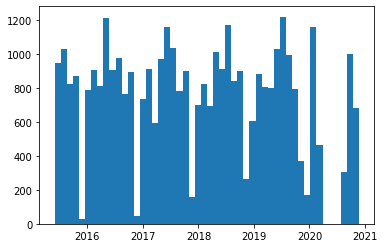

In [160]:
plt.hist(df.index.get_level_values('date'), bins=50);

In [161]:
df['p1_age'] = (df.index.get_level_values('date') - df['p1_birth']).dt.days / 365
df['p2_age'] = (df.index.get_level_values('date') - df['p2_birth']).dt.days / 365

In [162]:
df['p1_birthday_today'] = \
    (df['p1_birth'].dt.month == df.index.get_level_values('date').month) & \
    (df['p1_birth'].dt.day == df.index.get_level_values('date').day)

df['p2_birthday_today'] = \
    (df['p2_birth'].dt.month == df.index.get_level_values('date').month) & \
    (df['p2_birth'].dt.day == df.index.get_level_values('date').day)

In [163]:
df['hour'] = df['time'].map(lambda x: x.hour)

In [164]:
df['Surface'] = df['Surface'].fillna('N/A')

surface_encoder = OrdinalEncoder()
df['Surface'] = surface_encoder.fit_transform(df['Surface'].values.reshape(-1,1)); ## Clay - 0.0, Grass - 1.0, Hard outdoor - 3.0, Hard court indoor - 2.0 

In [165]:
df['round'] = df['round'].fillna('N/A')

round_encoder = OrdinalEncoder()
df['round'] = round_encoder.fit_transform(df['round'].values.reshape(-1,1));

In [166]:
stats = []
for x in df.keys():
    if 'match' in x and 'player1' in x:
        stats.append(x)
stats.pop(0)
df_new = lagged_features(df, target_var=stats, aggregation_methods=['mean', 'median'])
df_new = lagged_features(df, target_var=['match_duration_mnt'], aggregation_methods=['mean', 'median'])

In [173]:
df_new.rename(columns={"player1": "p1", "player2": "p2", "player1_win": "p1_win"}, inplace=True)

In [176]:
df_new = df_new.set_index(["date", "p1", "p2"])

In [177]:
features_from = '2014-01-01'

cols2keep = [
    'Surface', 'hour', 'round', 'p1_win',
    'p1_age', 'p2_age', 'k1', 'k2', 'p1_height', 'p2_height',
    'p1_birthday_today', 'p2_birthday_today'
]
for x in df_new.keys():
    if 'lag' in x:
        cols2keep.append(x)

data = df_new.loc[df_new.index.get_level_values('date') > features_from, cols2keep] \
    .dropna(subset=['p1_win'])
print(data.shape[0])
data.head(3)

36814


Surface  hour  round  p1_win     p1_age  \
date       p1         p2                                                     
2015-06-01 Gasquet R. Djokovic N.      0.0    18    1.0       0  28.046575   
           Nadal R.   Sock J.          0.0    17    1.0       1  22.698630   
           Chardy J.  Murray A.        0.0    13    1.0       0  28.065753   

                                      p2_age     k1    k2  p1_height  \
date       p1         p2                                               
2015-06-01 Gasquet R. Djokovic N.  28.972603  19.00  1.00       1.88   
           Nadal R.   Sock J.      29.013699   1.07  9.00       1.91   
           Chardy J.  Murray A.    28.317808   8.00  1.08       1.91   

                                   p2_height  p1_birthday_today  \
date       p1         p2                                          
2015-06-01 Gasquet R. Djokovic N.       1.83              False   
           Nadal R.   Sock J.           1.85              False   
           Chardy J.  Murray A.         1.88              False   

                                   p2_birthday_today  \
date       p1         p2                               
2015-06-01 Gasquet R. Djokovic N.              False   
           Nadal R.   Sock J.                  False   
           Chardy J.  Murray A.                False   

                                   p1_lag_1_match_duration_mnt_mean_28  \
date       p1         p2                                                 
2015-06-01 Gasquet R. Djokovic N.                                  NaN   
           Nadal R.   Sock J.                                      NaN   
           Chardy J.  Murray A.                                    NaN   

                                   p1_lag_1_match_duration_mnt_median_28  \
date       p1         p2                                                   
2015-06-01 Gasquet R. Djokovic N.                                    NaN   
           Nadal R.   Sock J.                                        NaN   
           Chardy J.  Murray A.                                      NaN   

                                   p1_filter_lag_1_match_duration_mnt_mean_28  \
date       p1         p2                                                        
2015-06-01 Gasquet R. Djokovic N.                                         NaN   
           Nadal R.   Sock J.                                             NaN   
           Chardy J.  Murray A.                                           NaN   

                                   p1_filter_lag_1_match_duration_mnt_median_28  \
date       p1         p2                                                          
2015-06-01 Gasquet R. Djokovic N.                                           NaN   
           Nadal R.   Sock J.                                               NaN   
           Chardy J.  Murray A.                                             NaN   

                                   p2_lag_1_match_duration_mnt_mean_28  \
date       p1         p2                                                 
2015-06-01 Gasquet R. Djokovic N.                                  NaN   
           Nadal R.   Sock J.                                      NaN   
           Chardy J.  Murray A.                                    NaN   

                                   p2_lag_1_match_duration_mnt_median_28  \
date       p1         p2                                                   
2015-06-01 Gasquet R. Djokovic N.                                    NaN   
           Nadal R.   Sock J.                                        NaN   
           Chardy J.  Murray A.                                      NaN   

                                   p2_filter_lag_1_match_duration_mnt_mean_28  \
date       p1         p2                                                        
2015-06-01 Gasquet R. Djokovic N.                                         NaN   
           Nadal R.   Sock J.                                             NaN   
           Chard

In [ ]:
## lag1
## _mdur(исходная статистика)
## _method
## _window
## _surfacetype(all, surface_name)

In [ ]:
## Информация о players:
## 148 players len(name + surname) > 2
## 1217 players len(name + surname) == 2
## 11 countries, not players
## Идея: сначала сделать fix_name по принципу: берем последнее слово из player1.split() в качестве фамилии, а затем fix_name:
## берем все слова с первого из player1.split() в качестве фамилии
## Итог: Выкинуто 50 игроков и их матчи(почти все малоизвестные)

In [ ]:
## НЕПРИЯТНО: у 6к матчей нет k1 k2(матчи в 2014) - по сути дроп всех матчей 2014 года

In [245]:
data.to_pickle('final_data.pkl')